## Lecture 4 - MIR for non-Western music traditions - 2
### Saraga annotations samples

This notebook was written for the tutorial offered at the 19th ISMIR Conference in Paris, France, on September 23rd, 2018 titled ["Computational Approaches for Analysis of Non-Western Music Traditions"](https://www.upf.edu/web/mtg/non-western-music-tutorial).
It aims at demonstrating some of the contents of Saraga database annotations: sections, typical phrases, sama and tempo annotations. It is assumed that the notebook downloadAllSARAGAContent.ipynb has been run and data is downloaded in two folders: 'hindustani' and 'carnatic'.

The particular file for which we demonstrate the annotations is set in cell 2. To pick another file and simply change the wave file name.

In [1]:
import os, json
from essentia.standard import *
from essentia import array
import matplotlib.pyplot as plt
import numpy as np
import IPython

fs = 44100

In [2]:
#Carnatic samples
music_tradition = 'carnatic'
wav_file = music_tradition + '/Cherthala Ranganatha Sharma - Bhuvini Dasudane.mp3'
#wav_file = music_tradition + '/Akkarai Sisters - Koti Janmani.mp3'

#Hindustani samples
#music_tradition = 'hindustani'
#wav_file = music_tradition + '/Omkar Dadarkar - Bhairavi Dadra.mp3'
#wav_file = music_tradition + '/Ajoy Chakrabarty - Bilaskhani Todi.mp3'


#Annotation files
metadata_file = wav_file.replace('.mp3', '.json')
phrase_annot_file = wav_file.replace('.mp3', '.mphrases-manual.txt')
sama_annot_file = wav_file.replace('.mp3', '.sama-manual.txt')
bpm_annot_file = wav_file.replace('.mp3', '.bpm-manual.txt')
section_annot_file = wav_file.replace('.mp3', '.sections-manual.txt')
tonic_file = wav_file.replace('.mp3', '.ctonic.txt')

#Reading files(audio and annotations)
sound_sig = MonoLoader(filename = wav_file, sampleRate = fs)()
with open(metadata_file) as json_data:
    metadata = json.load(json_data)
phrase_annotations = np.loadtxt(phrase_annot_file, dtype = {'names': ('start', 'dummy', 'duration', 'phrase'),'formats': ('f4', 'i4', 'f4', 'S32')})
sama_annotations = np.loadtxt(sama_annot_file)
tonic = np.loadtxt(tonic_file)
bpm_annotations = []
with open(bpm_annot_file) as fin:
    for line in fin:
        line = line.replace('-,', '-1,')#tempo-free sections have '-' label, better to set it to -1 for simplicity of conversion 
        bpm_annotations.append(tuple([float(i) for i in line.split(',')]))
section_annotations = []
with open(section_annot_file) as fin:
    for line in fin:
        line = line.strip().replace('\t', ',')#hindustani uses comma seperator, carnatic tab seperator, this line unifies
        pList = line.split(',')
        section_annotations.append(tuple([float(pList[0]), float(pList[1]), float(pList[2]), pList[3]]))

In [3]:
#Print short info on the recording
#print('Raaga: ',metadata['raaga'][0]['name'],',\tTaala: ',metadata['taala'][0]['name'])
print('MusicBrainz link: ', 'https://musicbrainz.org/recording/' + metadata['mbid'])
print('Tonic: ', tonic, ' Hz')
#Printing sections
print('\033[1m' + '\nSection\t\tStart\t\tStop' + '\033[0m')
for (start, dummy, duration, section) in section_annotations:
    print(section, '\t', start, '\t', start + duration)
#Printing bpm annotations
print('\033[1m' + '\nBPM\tStart\t\tStop' + '\033[0m')
for (bpm, start, stop) in bpm_annotations:
    print(bpm, '\t', start, '\t', stop)

MusicBrainz link:  https://musicbrainz.org/recording/9f5a5452-14cb-4af0-9289-4833854ee60d
Tonic:  201.74089  Hz

Section		Start		Stop
pallavi 	 0.065306122 	 85.28979591699999
anupallavi 	 85.35510204 	 166.857142856
charanam 	 167.314285714 	 308.767346938

BPM	Start		Stop
82.0 	 0.065306122 	 85.35510204
82.0 	 85.35510204 	 167.314285714
82.0 	 167.314285714 	 309.342040816


### Typical phrases
Let's extract some phrases available in the phrase level annotations 

In [ ]:
phrase_dict = {}#let's collect all occurences of each phrase in a list and map that info phrase name
for (start_sec, dummy,duration_sec, phrase) in phrase_annotations:
    start_ind = int(fs * start_sec)
    stop_ind = start_ind + int(fs * duration_sec)
    if phrase in phrase_dict.keys():
        segments = phrase_dict[phrase]
        segments.append((start_ind, stop_ind))
        phrase_dict[phrase] = segments
    else:
        phrase_dict[phrase] = [(start_ind, stop_ind)]

for phrase in phrase_dict.keys():
    print(phrase.decode())
    segments = phrase_dict[phrase]
    for (start_ind, stop_ind) in segments:
        phrase_sig = sound_sig[start_ind:stop_ind]
        IPython.display.display(IPython.display.Audio(phrase_sig, rate = fs))
#When run, the code in this cell will embed extracted phrases as output below (which you can click-play and listen) 

## Rhythmic cycles
Sama annotations include begining of cycles. Let's view some cycles, also extract automatically beats and visualize all together.
For a simple introduction to tala with examples, refer to: http://compmusic.upf.edu/examples-taala-carnatic

To also demonstrate accessing section information, we will be using the cycles in the second section, also comparing annotated tempo and tempo estimated suing the Rhythm Extractor implementation in Essentia

In [5]:
#Section selection is performed in this cell
#We will display second section content, id=1
selected_section_ind = 1
(section_start, dummy, section_duration, section_tag) = section_annotations[selected_section_ind]
section_stop=section_start+section_duration
(section_bpm, bpm_start, bpm_stop) = bpm_annotations[selected_section_ind]
print('Section: ', section_tag, ' , annotated bpm: ', section_bpm)
print('Location in audio: (start,stop in secs): ', section_start, section_stop)

#Extracting corresponding sama annnotations in the section
sama_annotations_seg = sama_annotations[np.logical_and(sama_annotations >= section_start, sama_annotations < section_stop)]
start_seg = sama_annotations_seg[0]
stop_seg = sama_annotations_seg[-1]
sama_annotations_seg = sama_annotations_seg - start_seg

Section:  anupallavi  , annotated bpm:  82.0
Location in audio: (start,stop in secs):  85.35510204 166.857142856


### Comparing annotations and estimation
Below, we use rhythm extractor in Essentia to estimate beats for the selected section. 
Sama annotations and beats are sonified together with the original audio.
We also plot annotated tempo versus estimated tempo

Audio with sonified sama annotations(beeps) and estimated beats(clicks)


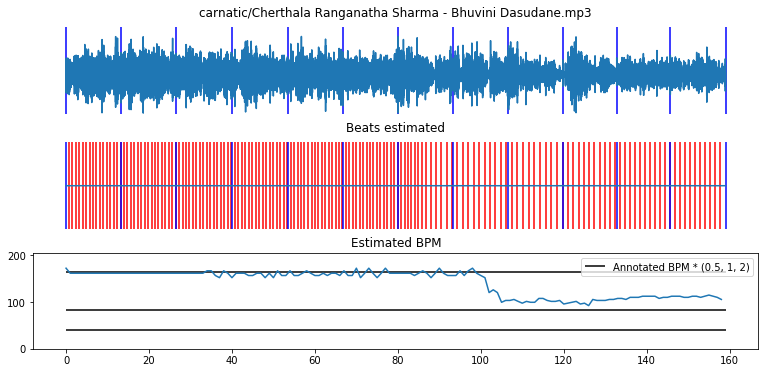

In [6]:
#Beat detection using Essentia

#Plotting
sound_sig_seg = sound_sig[int(start_seg * fs):int(stop_seg * fs)]
t = np.arange(sound_sig_seg.size)/float(fs)
zero_array = t * 0 #used only for plotting purposes
f, axarr = plt.subplots(3,1,figsize=(13, 6))
axarr[0].plot(t, sound_sig_seg);
axarr[0].set_title(wav_file);axarr[0].axis('off')
axarr[0].vlines(sama_annotations_seg, -1, 1.2, color = 'b')

rhythm_extractor = RhythmExtractor2013(method = "multifeature")
bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(sound_sig_seg)
onsetMarker = AudioOnsetsMarker(onsets = beats, type = 'noise')
samaMarker = AudioOnsetsMarker(onsets = array(sama_annotations_seg), type = 'beep')
marked_sound_sig = samaMarker(onsetMarker(sound_sig_seg))

axarr[1].plot(t, zero_array);
axarr[1].set_title('Beats estimated');
axarr[1].axis('off')
axarr[1].vlines(beats, -1, 1, color='r')
axarr[1].vlines(sama_annotations_seg, -1, 1, color='b')


axarr[2].plot(60/beats_intervals);
axarr[2].set_title('Estimated BPM');
axarr[2].hlines([section_bpm/2, section_bpm, section_bpm * 2], 0, len(beats_intervals), color = 'k', label = 'Annotated BPM * (0.5, 1, 2)')
axarr[2].legend()
axarr[2].set_ylim(0, section_bpm*2.5)

print('Audio with sonified sama annotations(beeps) and estimated beats(clicks)')
IPython.display.Audio(marked_sound_sig, rate=fs)